# Setting up libraries and constants

In [11]:

import importlib.util
import matplotlib.animation as animation
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.constants import c
from IPython.display import display, Math

In [12]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

In [13]:
lumapiFile = r"C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
spec = importlib.util.spec_from_file_location("lumapi", lumapiFile)
lumapi = importlib.util.module_from_spec(spec)
spec.loader.exec_module(lumapi)
ict_api = lumapi.INTERCONNECT(hide = False)

C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py:796: SyntaxWarning: invalid escape sequence '\s'
  message = re.sub('^(Error:)\s(prompt line)\s[0-9]+:', '', str(rvals[2])).strip()


In [14]:
ict_api.expressioncheckoff()

In [15]:
um = 1e-6
nm = 1e-9

In [53]:
lambda_0 = 1550*nm
delta=[562.61953067 * um,56.26195306700001 * um, 28.130976533500004 * um,]
L=50*um
neff=2.3531702
ng=4.3458796

ng_pdk=4.19088
fsr_ofc = np.array([1.0, 10.0, 20.0])

delta_L = lambda_0**2 / (fsr_ofc*nm*ng_pdk)


# Ideal MZI simulation

## Making the circuit

In [80]:
ict_api.switchtodesign()
ict_api.deleteall()
ict_api.addelement('Optical Network Analyzer')
ict_api.set('name','ONA')
ict_api.set('number of points',10000)
ict_api.set('input parameter',2)
ict_api.set('start frequency',c/(1500*nm))
ict_api.set('stop frequency',c/(1600*nm))
ict_api.setposition('ONA',0,0)

ict_api.addelement('Waveguide Combiner')
ict_api.set('name','combiner')
ict_api.setposition('combiner',200,200)
ict_api.addelement('Waveguide Splitter')
ict_api.set('name','splitter')
ict_api.setposition('splitter',-200,200)
ict_api.addelement('Straight waveguide')
ict_api.set('name','wvg01')
ict_api.set('effective index 1',neff)
ict_api.set('group index 1',ng)
ict_api.set('length',L)
ict_api.setposition('wvg01',0,150)
ict_api.addelement('Straight waveguide')
ict_api.set('name','wvg02')
ict_api.set('effective index 1',neff)
ict_api.set('group index 1',ng)
ict_api.setposition('wvg02',0,250)

ict_api.connect("ONA", "output", "splitter", "input")
ict_api.connect("splitter", "output 1", "wvg01", "port 1")
ict_api.connect("splitter", "output 2", "wvg02", "port 1")
ict_api.connect("wvg01", "port 2", "combiner", "input 1")
ict_api.connect("wvg02", "port 2", "combiner", "input 2")
ict_api.connect("combiner", "output", "ONA", "input 1")

1.0

## Running the simulation

In [ ]:
gain_ideal = []
fsr_ideal = []
for i in range (3):
    
    ict_api.switchtodesign()
    ict_api.select('wvg02')
    ict_api.set('length',L+delta[i])
    if(i==0):
        ict_api.select('ONA')
        ict_api.set('number of points',100000)
    ict_api.run()
    
    gain = (ict_api.getresult("ONA", "input 1/mode 1/gain"))
    gain_ideal.append(gain)
    
    fsr = (ict_api.getresult("ONA", 'input 1/mode 1/peak/free spectral range'))
    fsr_ideal.append(fsr)
    


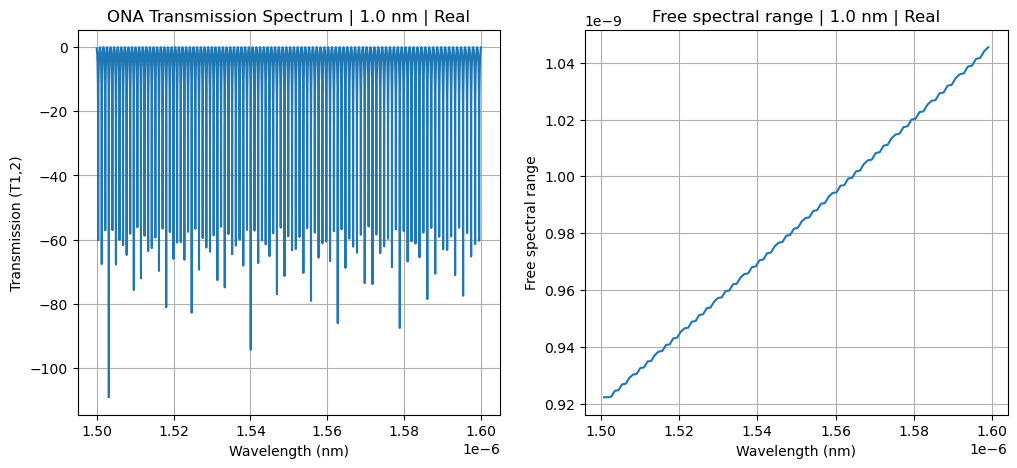

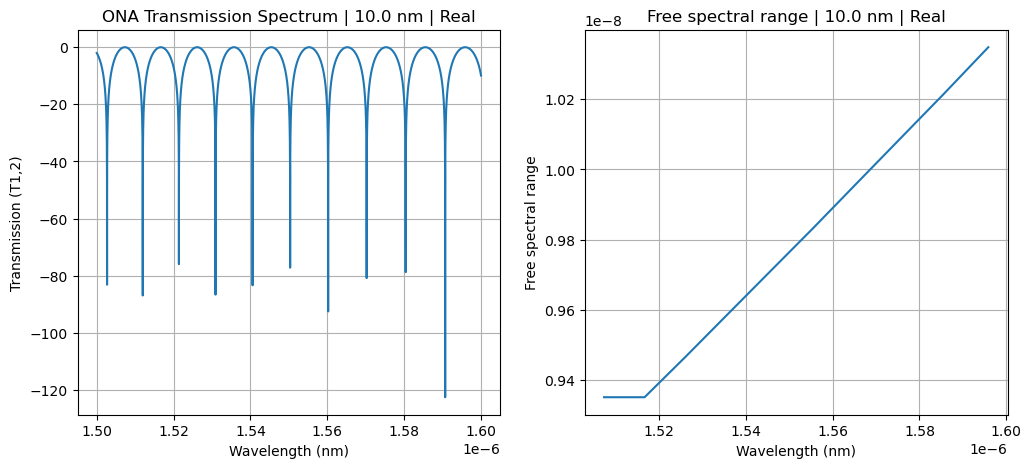

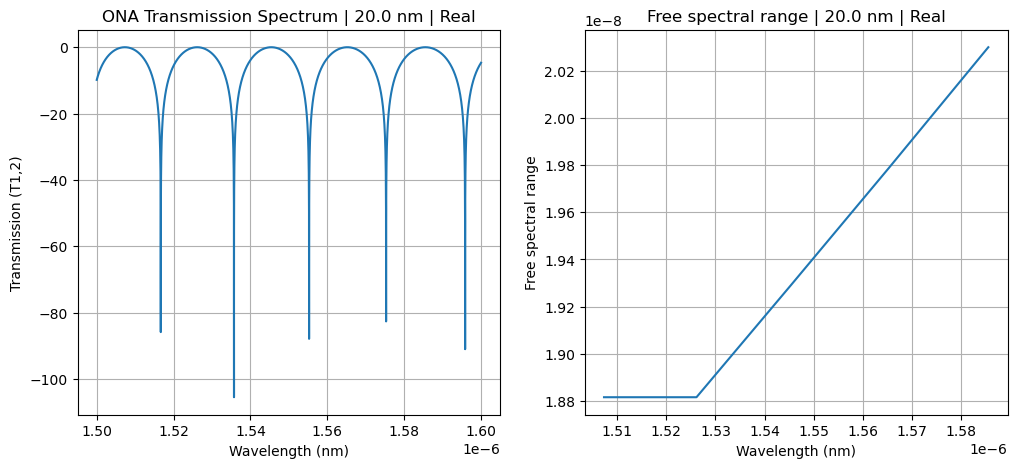

In [122]:
for i in range(3):
    fig, axs = plt.subplots(1,2,  figsize=(12, 5))
    axs[0].plot(gain_ideal[i]['wavelength'], gain_ideal[i]['TE gain (dB)'])
    axs[0].set_xlabel('Wavelength (nm)')
    axs[0].set_ylabel('Transmission (T1,2)')
    axs[0].set_title(f'ONA Transmission Spectrum | {fsr_ofc[i]} nm | Real')
    axs[0].grid(True)
    
    
    
    axs[1].plot(fsr_ideal[i]['wavelength'], fsr_ideal[i]["TE free spectral range (m)"])
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel('Free spectral range')
    axs[1].set_title(f'Free spectral range | {fsr_ofc[i]} nm | Real')
    axs[1].grid(True)
    
    plt.show()

# Real MZI simulation

## Making the circuit

In [115]:
ict_api.switchtodesign()
ict_api.deleteall()
ict_api.addelement('Optical Network Analyzer')
ict_api.set('name','ONA')
ict_api.set('number of points',10000)
ict_api.set('input parameter',2)
ict_api.set('start frequency',c/(1500*nm))
ict_api.set('stop frequency',c/(1600*nm))
ict_api.setposition('ONA',0,0)

ict_api.addelement('Optical N port S-Parameter')
ict_api.set('name','combiner')
ict_api.set('load from file', 1)
ict_api.set('s parameters filename', r'C:\Users\juame\Downloads\MZI\s_parameter.dat')
ict_api.setposition('combiner',200,200)
ict_api.rotateelement('combiner')
ict_api.rotateelement('combiner')
ict_api.addelement('Optical N port S-Parameter')
ict_api.set('name','splitter')
ict_api.set('load from file', 1)
ict_api.set('s parameters filename', r'C:\Users\juame\Downloads\MZI\s_parameter.dat')
ict_api.setposition('splitter',-200,200)
ict_api.addelement('MODE Waveguide')
ict_api.set('ldf filename', r"C:\Users\juame\Downloads\MZI\wvg.ldf")
ict_api.set('name','wvg01')
ict_api.set('length',L)
ict_api.setposition('wvg01',0,150)
ict_api.addelement('MODE Waveguide')
ict_api.set('ldf filename', r"C:\Users\juame\Downloads\MZI\wvg.ldf")
ict_api.set('name','wvg02')
ict_api.setposition('wvg02',0,250)

ict_api.connect("ONA", "output", "splitter", "in")
ict_api.connect("splitter", "out_1", "wvg01", "port 1")
ict_api.connect("splitter", "out_2", "wvg02", "port 1")
ict_api.connect("wvg01", "port 2", "combiner", "out_2")
ict_api.connect("wvg02", "port 2", "combiner", "out_1")
ict_api.connect("combiner", "in", "ONA", "input 1")

1.0

## Running the simulation

In [ ]:
gain_real = []
fsr_real = []

for i in range (3):
    
    ict_api.switchtodesign()
    ict_api.select('wvg02')
    ict_api.set('length',L+delta[i])
    if(i==0):
        ict_api.select('ONA')
        ict_api.set('number of points',100000)
    ict_api.run()
    
    gain = (ict_api.getresult("ONA", "input 1/mode 1/gain"))
    gain_real.append(gain)
    
    fsr = (ict_api.getresult("ONA", 'input 1/mode 1/peak/free spectral range'))
    fsr_real.append(fsr)



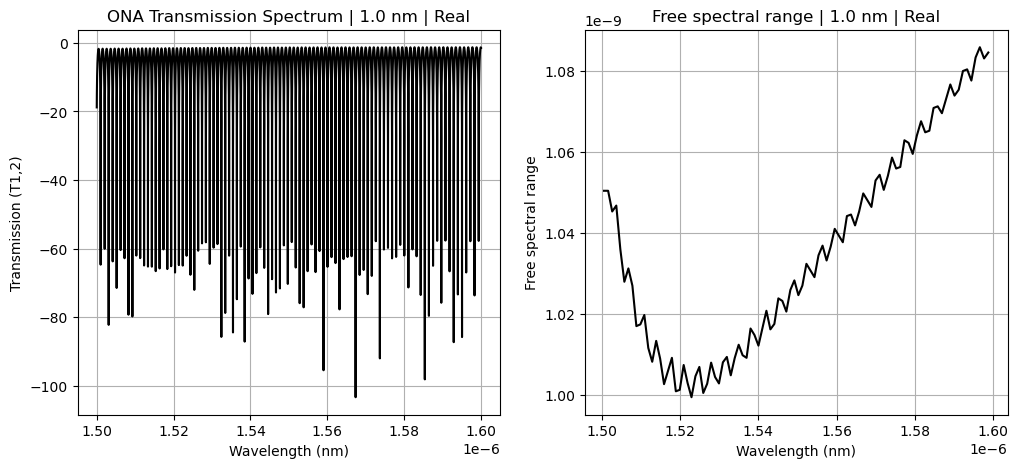

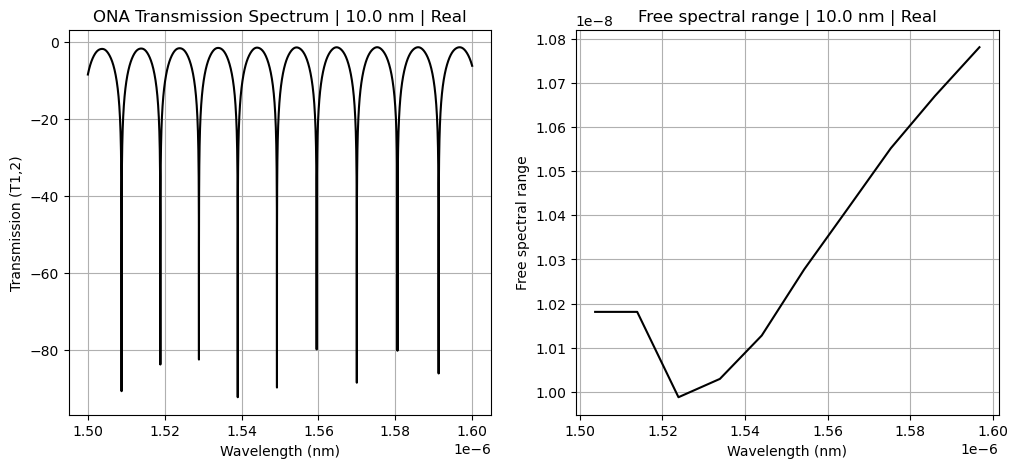

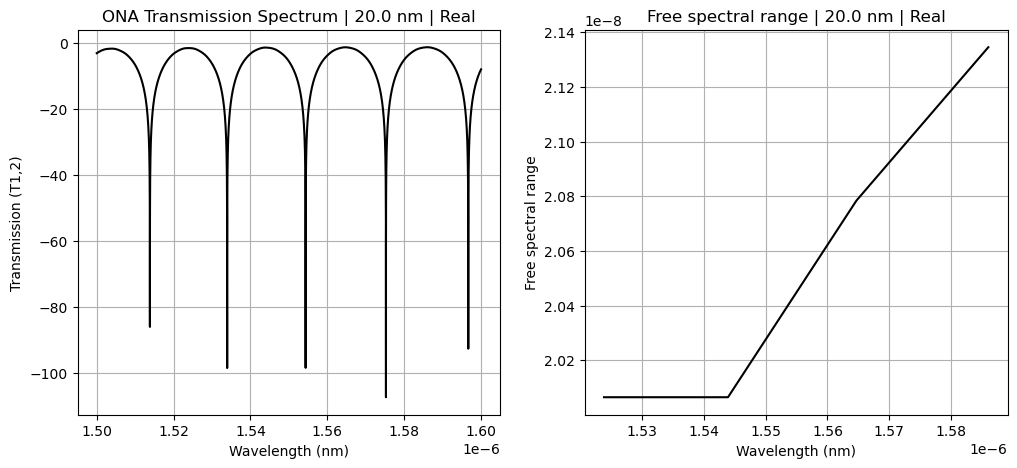

In [120]:
for i in range (3):
    
    fig, axs = plt.subplots(1,2,  figsize=(12, 5))
    axs[0].plot(gain_real[i]['wavelength'], gain_real[i]['mode 1 gain (dB)'],color='black')
    axs[0].set_xlabel('Wavelength (nm)')
    axs[0].set_ylabel('Transmission (T1,2)')
    axs[0].set_title(f'ONA Transmission Spectrum | {fsr_ofc[i]} nm | Real')
    axs[0].grid(True)
    
    
    axs[1].plot(fsr_real[i]['wavelength'], fsr_real[i]["mode 1 free spectral range (m)"],color='black')
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel('Free spectral range')
    axs[1].set_title(f'Free spectral range | {fsr_ofc[i]} nm | Real')
    axs[1].grid(True)
    plt.show()

# PDK MZI simulation

## Making the circuit

In [123]:
ict_api.switchtodesign()
ict_api.deleteall()
ict_api.addelement('Optical Network Analyzer')
ict_api.set('name','ONA')
ict_api.set('number of points',10000)
ict_api.set('input parameter',2)
ict_api.set('start frequency',c/(1500*nm))
ict_api.set('stop frequency',c/(1600*nm))
ict_api.setposition('ONA',0,0)

ict_api.addelement('ebeam_y_1550')
ict_api.set('name','combiner')
ict_api.setposition('combiner',200,200)
ict_api.rotateelement('combiner')
ict_api.rotateelement('combiner')
ict_api.addelement('ebeam_y_1550')
ict_api.set('name','splitter')
ict_api.setposition('splitter',-200,200)
ict_api.addelement('ebeam_wg_integral_1550')
ict_api.set('name','wvg01')
ict_api.set('wg_length',L)
ict_api.setposition('wvg01',0,150)
ict_api.addelement('ebeam_wg_integral_1550')
ict_api.set('name','wvg02')
ict_api.setposition('wvg02',0,250)

ict_api.connect("ONA", "output", "splitter", "opt_a1")
ict_api.connect("splitter", "opt_b1", "wvg01", "port 1")
ict_api.connect("splitter", "opt_b2", "wvg02", "port 1")
ict_api.connect("wvg01", "port 2", "combiner", "opt_b2")
ict_api.connect("wvg02", "port 2", "combiner", "opt_b1")
ict_api.connect("combiner", "opt_a1", "ONA", "input 1")

1.0

## Running the simulation

In [124]:
gain_pdk = []
fsr_pdk = []



for i in range (3):
    ict_api.switchtodesign()
    ict_api.select('wvg02')
    ict_api.set('wg_length',L+delta_L[i])
    if(i==0):
        ict_api.select('ONA')
        ict_api.set('number of points',100000)
    ict_api.run()
    gain = (ict_api.getresult("ONA", "input 1/mode 1/gain"))
    
    gain_pdk.append(gain)
    
    fsr = (ict_api.getresult("ONA", 'input 1/mode 1/peak/free spectral range'))
    fsr_pdk.append(fsr)



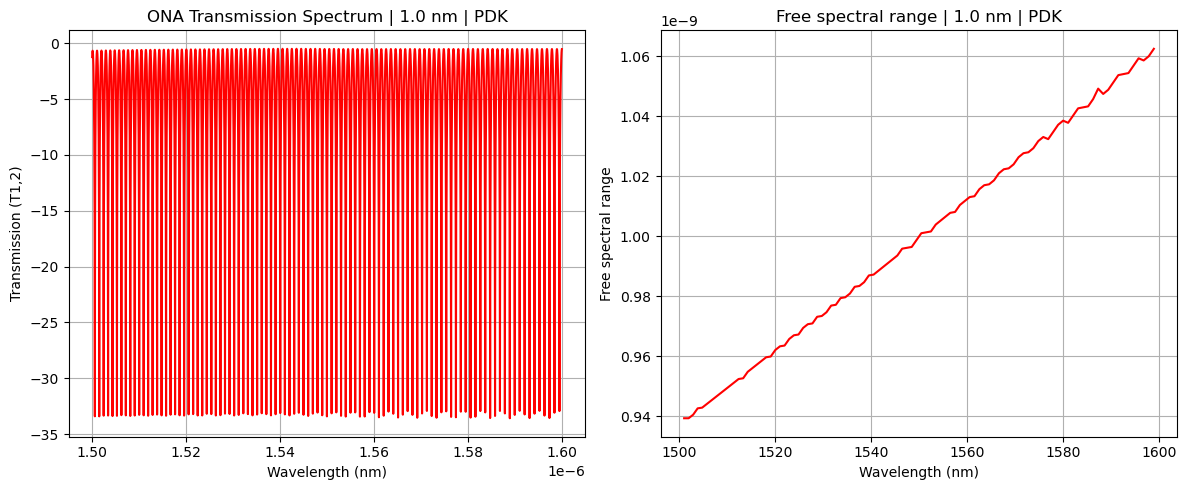

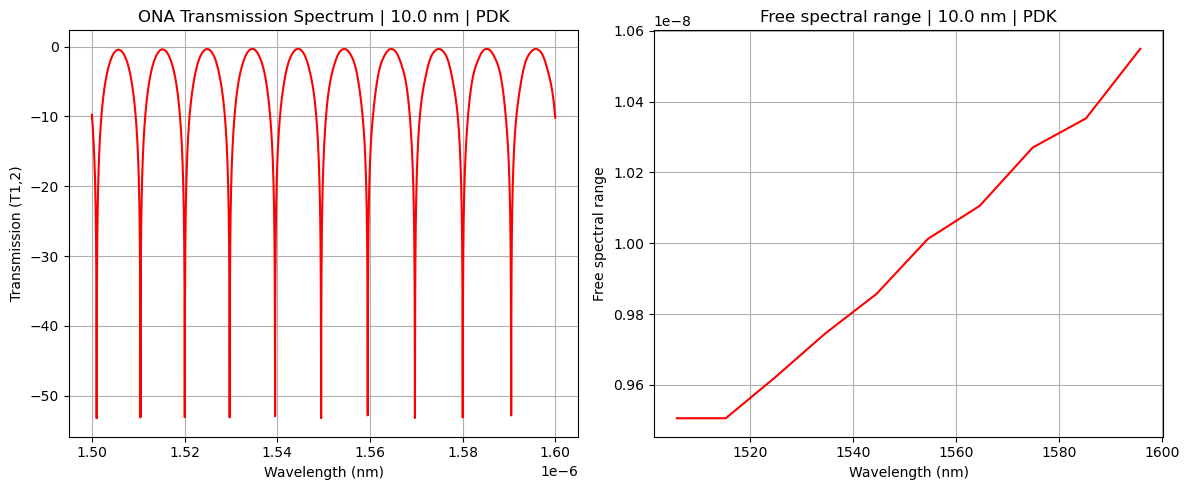

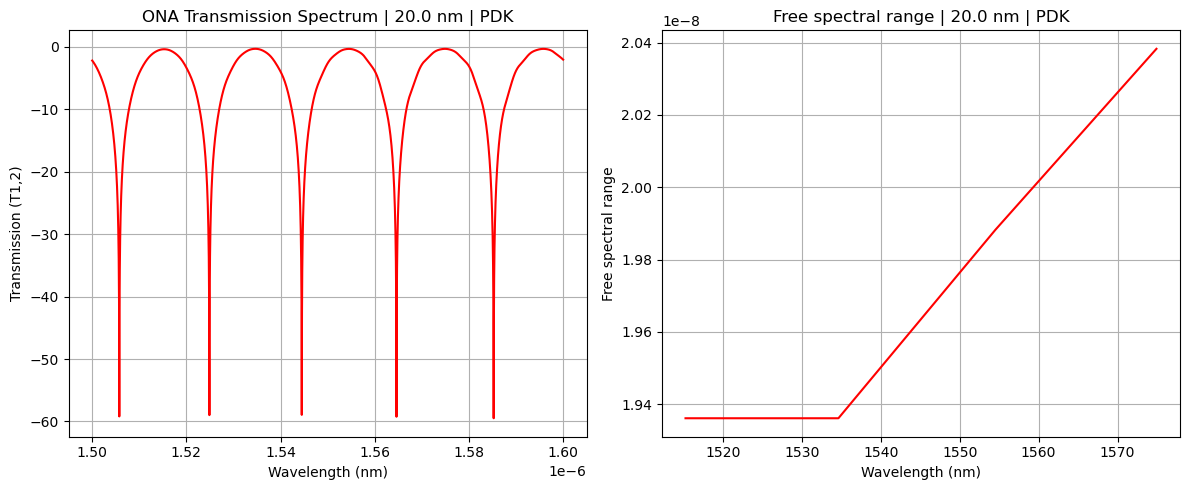

In [125]:
for i in range(3):
    fig, axs = plt.subplots(1,2,  figsize=(12, 5))
    axs[0].plot(gain_pdk[i]['wavelength'], gain_pdk[i]["'TE' gain (dB)"], color='red')
    axs[0].set_xlabel('Wavelength (nm)')
    axs[0].set_ylabel('Transmission (T1,2)')
    axs[0].set_title(f'ONA Transmission Spectrum | {fsr_ofc[i]} nm | PDK')
    axs[0].grid(True)
    
    axs[1].plot(fsr_pdk[i]['wavelength'] / nm, fsr_pdk[i]["'TE' free spectral range (m)"], color='red')
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel('Free spectral range')
    axs[1].set_title(f'Free spectral range | {fsr_ofc[i]} nm | PDK')
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# Comparing results

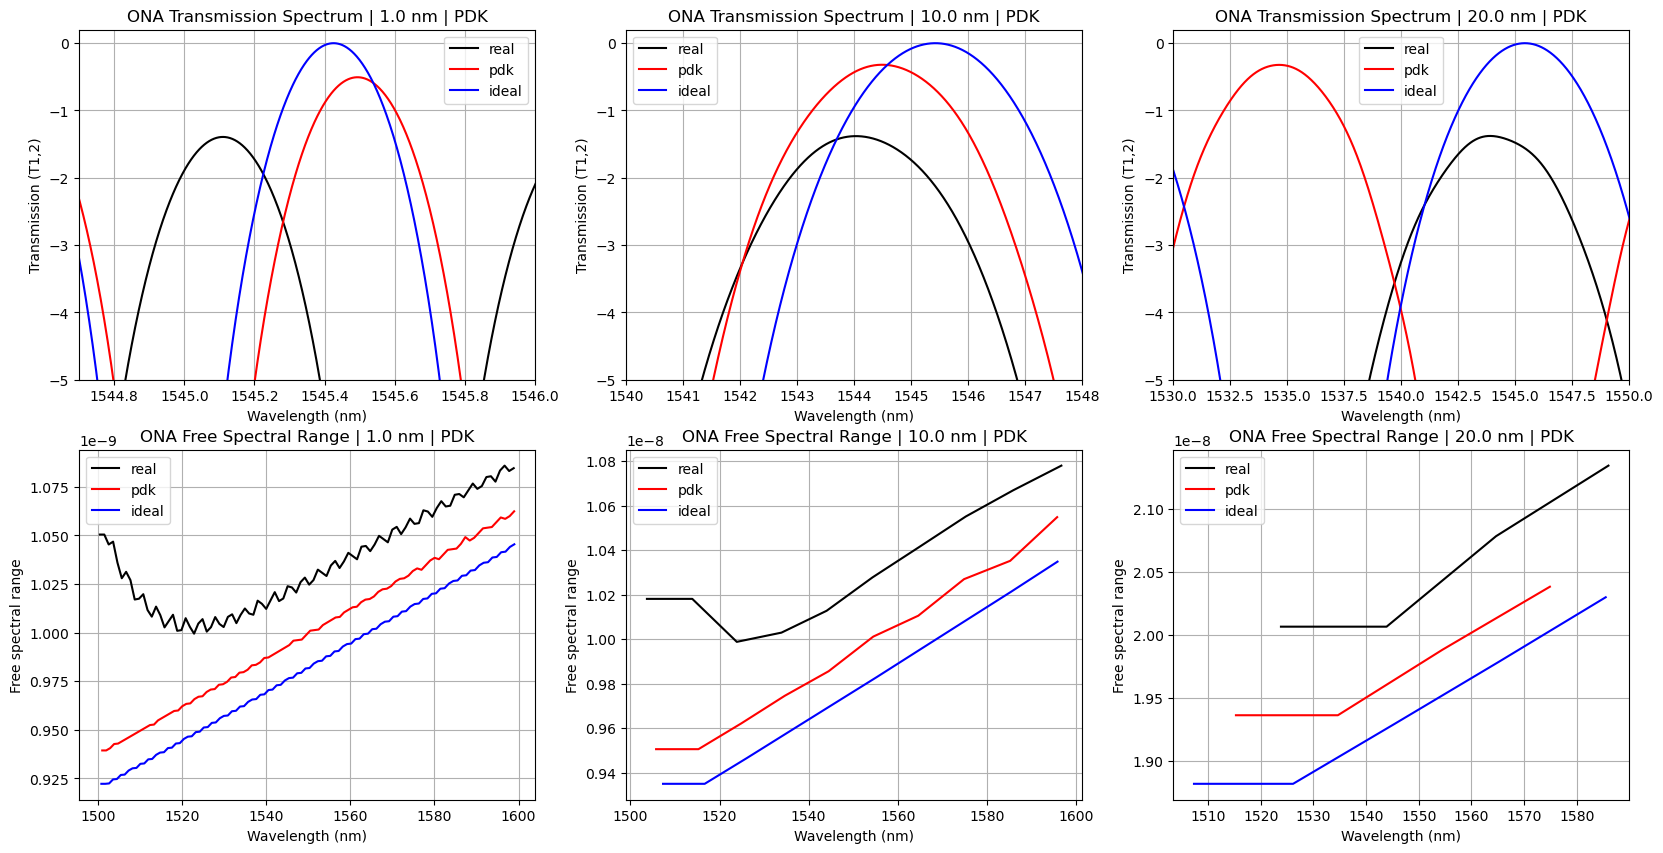

In [126]:
xlim={}
xlim[0] = [1544.7,1546]
xlim[1] = [1540,1548]
xlim[2] = [1530,1550]
fig, axs = plt.subplots(2,3,  figsize=(20, 10))
for i in range (3):
    axs[0,i].plot(gain_real[i]['wavelength'] / nm, gain_real[i]['mode 1 gain (dB)'],
            label='real', color='black')
    axs[0,i].plot(gain_pdk[i]['wavelength'] / nm, gain_pdk[i]["'TE' gain (dB)"],
            label='pdk', color='red')
    axs[0,i].plot(gain_ideal[i]['wavelength'] / nm, gain_ideal[i]["TE gain (dB)"],
            label='ideal', color='blue')
    axs[0,i].set_xlabel('Wavelength (nm)')
    axs[0,i].set_ylabel('Transmission (T1,2)')
    axs[0,i].set_title(f'ONA Transmission Spectrum | {fsr_ofc[i]} nm | PDK')
    axs[0,i].grid(True)
    axs[0,i].legend()
    axs[0,i].set_ylim(-5,0.2)
    axs[0,i].set_xlim(xlim[i])
    
for i in range (3):
    axs[1,i].plot(fsr_real[i]['wavelength'] / nm, fsr_real[i]['mode 1 free spectral range (m)'],
            label='real', color='black')
    axs[1,i].plot(fsr_pdk[i]['wavelength'] / nm, fsr_pdk[i]["'TE' free spectral range (m)"],
            label='pdk', color='red')
    axs[1,i].plot(fsr_ideal[i]['wavelength'] / nm, fsr_ideal[i]["TE free spectral range (m)"],
            label='ideal', color='blue')
    axs[1,i].set_xlabel('Wavelength (nm)')
    axs[1,i].set_ylabel('Free spectral range')
    axs[1,i].set_title(f'ONA Free Spectral Range | {fsr_ofc[i]} nm | PDK')
    axs[1,i].grid(True)
    axs[1,i].legend()
    
plt.show()